In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [2]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Natural Languague Processing 📝 A complete Guide</p>

**Natural Language Processing or NLP** is a branch of Artificial Intelligence which deal with bridging the machines understanding humans in their Natural Language. Natural Language can be in form of text or sound, which are used for humans to communicate each other. NLP can enable humans to communicate to machines in a natural way.

**Text Classification** is a process involved in Sentiment Analysis. It is classification of peoples opinion or expressions into different sentiments. Sentiments include Positive, Neutral, and Negative, Review Ratings and Happy, Sad. Sentiment Analysis can be done on different consumer centered industries to analyse people's opinion on a particular product or subject.

Natural language processing has its roots in the 1950s. Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, a task that involves the automated interpretation and generation of natural language, but at the time not articulated as a problem separate from artificial intelligence.

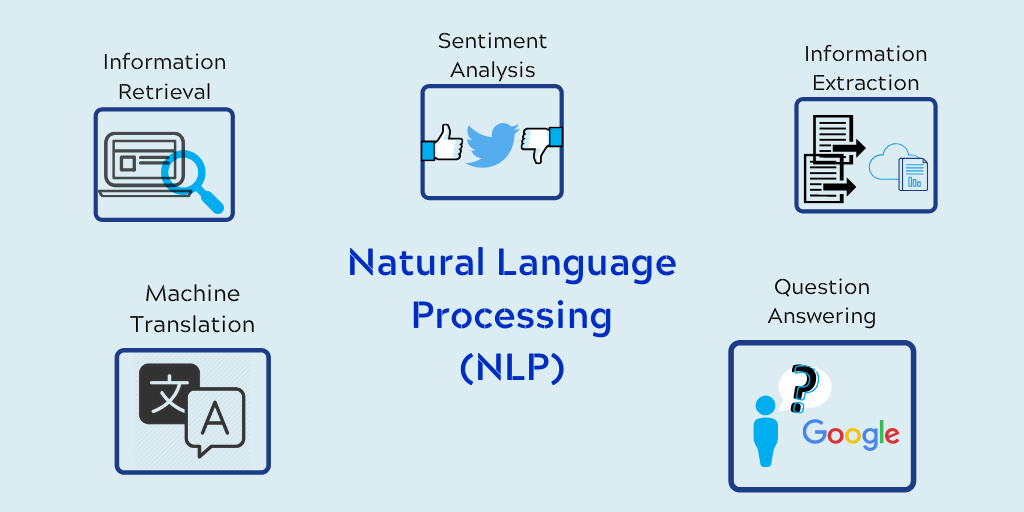

In this kernel we are going to focus on text classification and sentiment analysis part. In the next lessons we will study Information retrival, Question answering, etc

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning the corpus 🛠](#3.1)
    * [3.2 Stemming 🛠](#3.2)
    * [3.3 All together 🛠](#3.3)
    * [3.4 Target encoding 🛠](#3.4)
* [4. Tokens visualization 📊](#4)
* [5. Vectorization](#5)
    * [5.1 Tunning CountVectorizer](#5.1)
    * [5.2 TF-IDF](#5.2)
    * [5.3 Word Embeddings: GloVe](#5.3)
* [6. Modeling](#6)
    * [6.1 Naive Bayes DTM](#6.1)
    * [6.2 Naive Bayes TF-IDF](#6.2)
    * [6.3 XGBoost](#6.3)
* [7. LSTM](#7)
* [8. BERT](#8)
* [9. NLP: Disaster tweets](#9)
    * [9.1 EDA](#9.1)
    * [9.2 Data preprocessing](#9.2)
    * [9.3 WordCloud](#9.3)
    * [9.4 Modeling](#9.4)
    * [9.5 GloVe - LSTM](#9.5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>

Just load the dataset and global variables for colors and so on.

In [3]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [4]:
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [6]:
max(df['message_len'])

171

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Now we are going to take a look about the target distribution and the messages length.

**Balanced Dataset:** — Let’s take a simple example if in our data set we have positive values which are approximately same as negative values. Then we can say our dataset in balance.

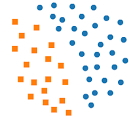

Consider Orange color as a positive values and Blue color as a Negative value. We can say that the number of positive values and negative values in approximately same.

**Imbalanced Dataset:** — If there is the very high different between the positive values and negative values. Then we can say our dataset in Imbalance Dataset.

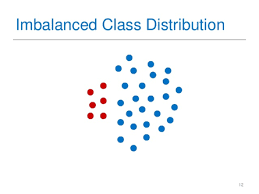



In [7]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [8]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [9]:
pip install nbformat --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.

In [10]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the `ham` message length tend to be lower than `spam` message length.

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Pre-processing 🛠</p>

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 Cleaning the corpus 🛠</p>

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some examples removing stopwords are:

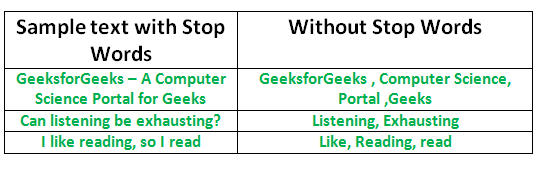

In [13]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


In [14]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.2 Stemming 🛠</p>

### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes*. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

**Stemming** usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

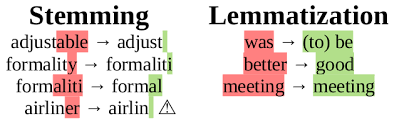

As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.

### Stemming algorithms

There are several stemming algorithms implemented in NLTK Python library:
1. **PorterStemmer** uses *Suffix Stripping* to produce stems. **PorterStemmer is known for its simplicity and speed**. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because *PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems*. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
2. One can generate its own set of rules for any language that is why Python nltk introduced **SnowballStemmers** that are used to create non-English Stemmers!
3. **LancasterStemmer** (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [15]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [16]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.3 All together 🛠</p>

In [17]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [18]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


<a id='3.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.4 Target encoding 🛠</p>

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Tokens visualization 📊</p>

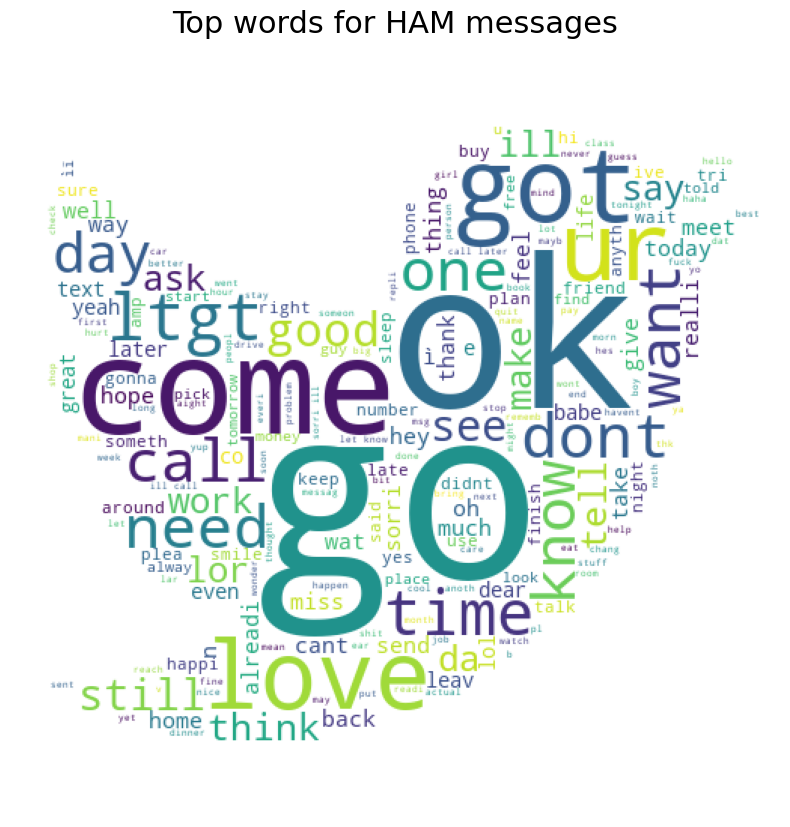

In [20]:
twitter_mask = np.array(Image.open('twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

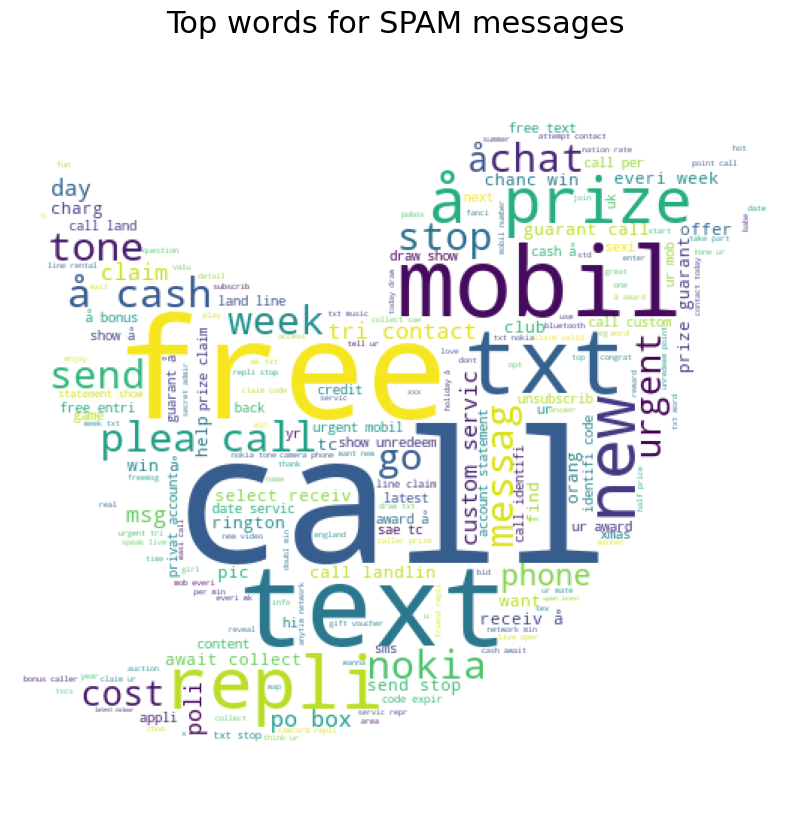

In [21]:
twitter_mask = np.array(Image.open('twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Vectorization</p>

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:



Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

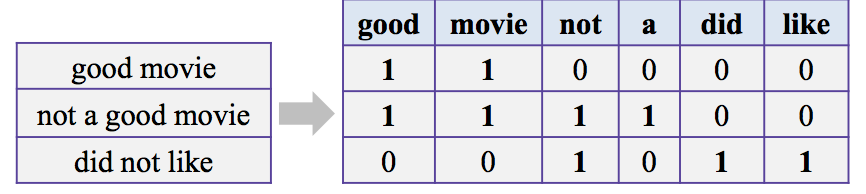

In [22]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [23]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [25]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.1 Tunning CountVectorizer</p>

CountVectorizer has a few parameters you should know.

1. **stop_words**: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. **ngram_range**: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

3. **min_df, max_df**: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. **max_features**: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else. 

You would set these parameters when initializing your CountVectorizer object as shown below.

In [26]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

<a id='5.2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.2 TF-IDF</p>

In information retrieval, tf–idf, **TF-IDF**, or TFIDF, **short for term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

**tf–idf** is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

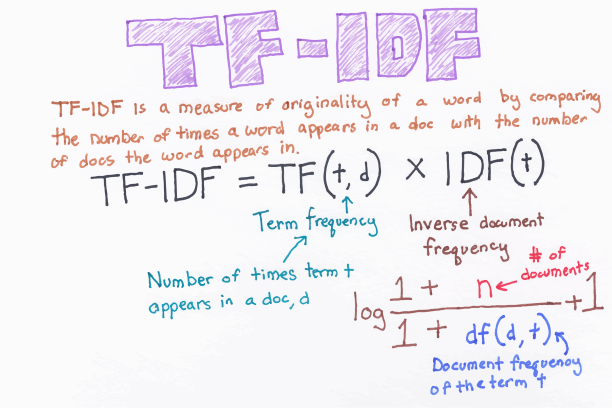

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32201 stored elements and shape (4179, 5684)>

<a id='5.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.3 Word Embeddings: GloVe</p>


In [28]:
texts = df['message_clean']
target = df['target_encoded']

We need to perform **tokenization** - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

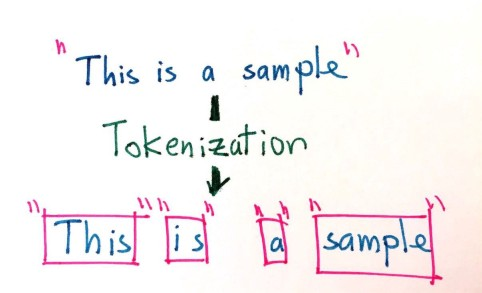

In [29]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

### Pad_sequences

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

```python
>>> sequence = [[1], [2, 3], [4, 5, 6]]
>>> tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)
```

In [30]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

### GloVe

GloVe method is built on an important idea,

> You can derive semantic relationships between words from the co-occurrence matrix.

To obtain a vector representation for words we can use an unsupervised learning algorithm called **GloVe (Global Vectors for Word Representation)**, which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [32]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open("glove.6B.100d.txt", "r", encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [33]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>

In [34]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. LSTM</p>

In [35]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [36]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix]
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       672,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,600 (2.57 MB)

 Trainable params: 672,600 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7876 - loss: 0.5143
Epoch 1: val_loss improved from inf to 0.31637, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7881 - loss: 0.5131 - val_accuracy: 0.9304 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9308 - loss: 0.1976
Epoch 2: val_loss improved from 0.31637 to 0.14711, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9308 - loss: 0.1976 - val_accuracy: 0.9519 - val_loss: 0.1471 - learning_rate: 0.0010
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9512 - loss: 0.1495
Epoch 3: val_loss improved from 0.14711 to 0.11586, saving model to model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9512 - loss: 0.1494 - val_accuracy: 0.9641 - val_loss: 0.1159 - learning_rate: 0.0010
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9718 - loss: 0

### Lets see the results

In [39]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

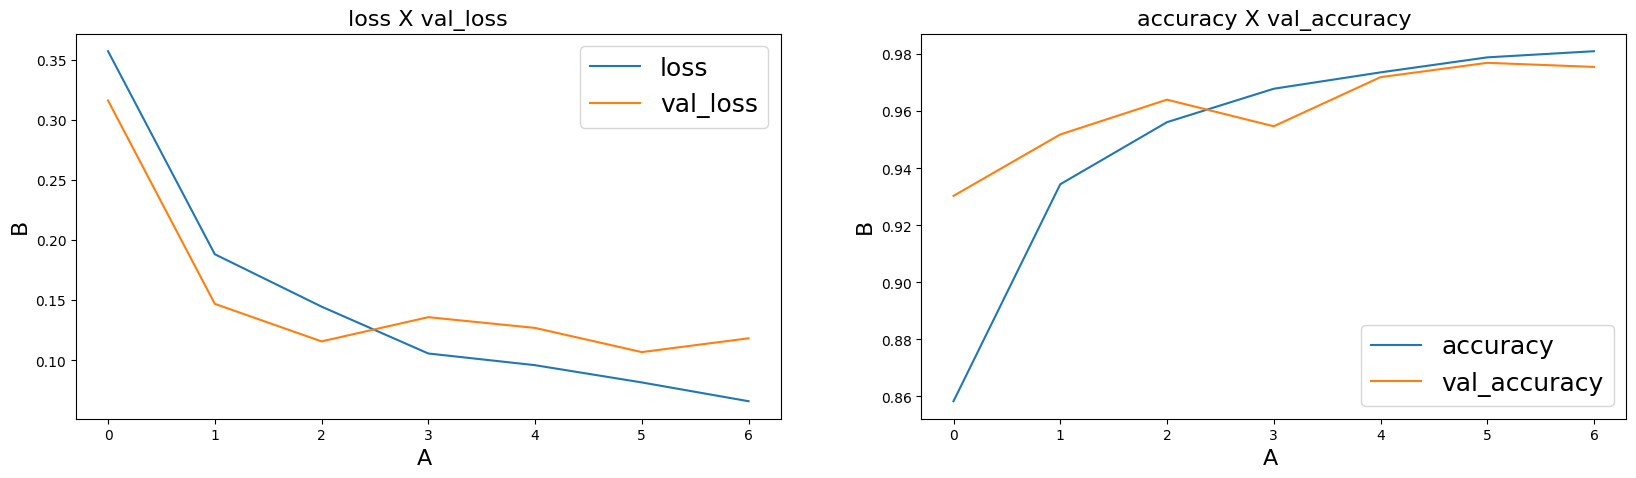

In [40]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [42]:
from sklearn import metrics

y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


The code above serves as a basic implementation for the spam detection problem. Based on this code, develop your own RNN-based model for the fake news dataset provided below. You may modify the RNN model, experiment with different architectures, and adjust parameters such as the word embedding method. Additionally, optimize your model for higher accuracy and other performance metrics. Ensure that you use an improved style for plotting graphs and presenting your results effectively.

Note that to run the provided code, you need to install various libraries, such as NLTK and spaCy. These can be installed using 'pip'. For example, NLTK can be installed with the following command: !pip install nltk.

Additionally, certain parts of the code, such as vectorization, have not been used, while word embedding has been implemented. You may incorporate vectorization in your code if needed.

Lab Logbook Requirement: Provide a graph showing the history of training and validation loss based on your code. You should enhance the style of the plot to make it more visually appealing and presentable.

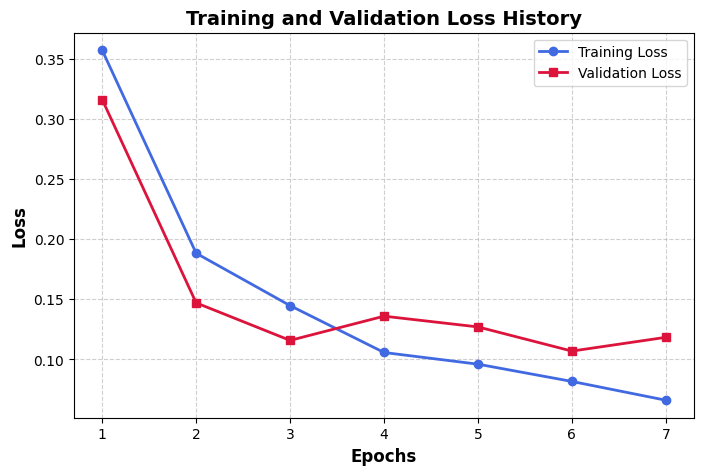

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'o-', label='Training Loss', color='royalblue', linewidth=2, markersize=6)
plt.plot(epochs, val_loss, 's-', label='Validation Loss', color='crimson', linewidth=2, markersize=6)


plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training and Validation Loss History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(epochs)
plt.yticks(fontsize=10)
plt.show()
